<a href="https://colab.research.google.com/github/mikeusru/scikit-learn-training/blob/main/unsupervised_learning_2_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning
## Clustering for Image Segmentation and Semi-Supervised Learning

We've looked at unsupervised learning for clustering and anomaly detection. Now let's look at a slightly different type of data - images. It's easy to forget that images are just a collection of features displayed in 2D, each pixel holding an array of three values (in an RGB image, at least). For compression, for example, these pixels can be clustered to more effeciently store the information in the image (compression).

## Clustering for Color Segmentation

In [2]:
import os
import matplotlib.cbook as cbook
from matplotlib import pyplot as plt

with cbook.get_sample_data('ada.png') as image_file:
    image = plt.imread(image_file)

image.shape

(803, 512, 4)

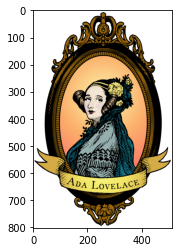

In [3]:
plt.imshow(image)

In the case of this image, there are 4 channels instead of 3. The png has a 4th layer which denotes transparency - if we remove it, we get a black background.

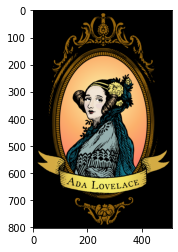

In [4]:
image_solid = image[:,:,:3]
plt.imshow(image_solid)

## K Means
We can now use k-means to categorize each pixel into a cluster. Next, we can recreate the image using just the cluster centers for our pixels, meaning we'll have way fewer values to store.

Note - although images are 2D matrices, we'll need to convert them to 1D arrays in order to feed them into our machine learning models. 

In [6]:
X = image_solid.reshape(-1,3)
X.shape

(411136, 3)

We now have three 1-D arrays, one for each color.

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image_solid.shape)

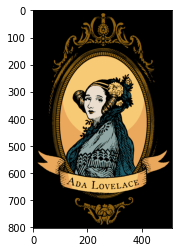

In [13]:
plt.imshow(segmented_img)

That's our recreated image, and you might notice the transitions between colors are sharper. Let's take a look at what happens when we choose even fewer clusters.

In [33]:
from sklearn.cluster import MiniBatchKMeans

def segment_image_by_color(image):
  X = image.reshape(-1,3)
  seg_img_dict = {}
  for k in [2,4,6,8,10]:
    kmeans = MiniBatchKMeans(n_clusters=k).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    seg_img_dict[k] = segmented_img.reshape(image.shape)
  return seg_img_dict

In [34]:
image_dict = segment_image_by_color(image_solid)

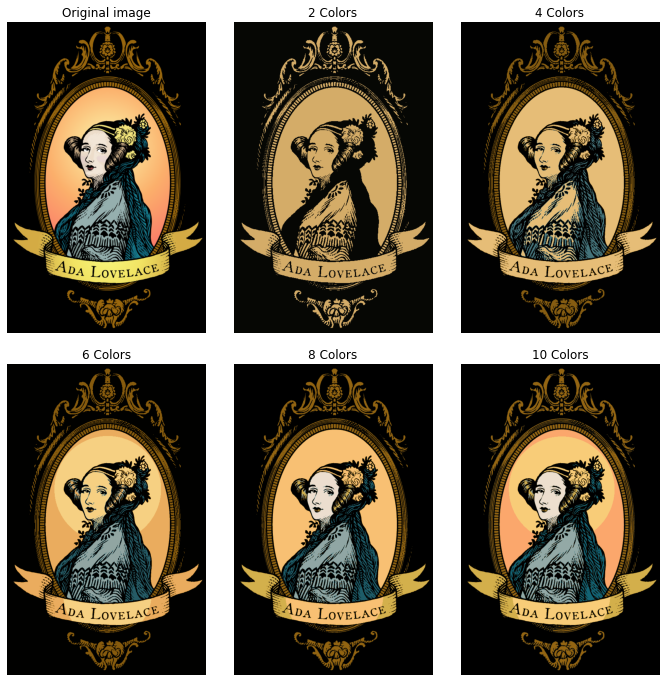

In [35]:
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image_solid)
plt.title("Original image")
plt.axis('off')

idx = 1
for k, img in image_dict.items():
  plt.subplot(231 + idx)
  idx += 1
  plt.imshow(image_dict[k])
  plt.title(f"{k} Colors")
  plt.axis('off')
  

This is the same technique used for a lot of image compression algorithms - you'll notice that 10 colors actually represents a good portion of this image, and it's hardly discernable from the original.

## Exercise 
use K means to cluster colors on the image found at the link below. Load the image directly from the link using code. This is an image of something called 'brainbow', where researchers created a genetically altered animal which expresses random colors in each neuron, leading to easily discernable brain cells.

http://cbs.fas.harvard.edu/usr/connectome/brainbow/brainbow2.1.jpg

## Preprocessing with Clustering
Clustering can be used as a preprocessing step to clean up the data before loading it into an algorithm. It reduces noise, and can help a classifier focus on meaningful features while avoiding noise. We're going to use the digits dataset, which contains 8x8 hand-written images of digits 0-9. 

In [36]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

What does this data look like? Each digit is loaded as a 1x64 array (flattened 8x8). We can reshape a sampled set of images to 2D matrices to take a look at them.

In [43]:
def show_sample_digits(sample_digits):
  plt.figure(figsize=(8,2))
  for index, sample_digit in enumerate(sample_digits):
      plt.subplot(5, 10, index + 1)
      plt.imshow(sample_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
      plt.axis('off')

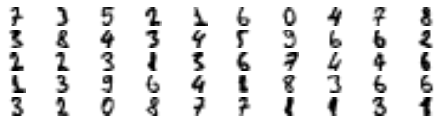

In [44]:
show_sample_digits(X_train[:50, :])

Coolcats. Now, let's use a really simple classifier, LogisticRegression, to predict the digit and get an accuracy score. 

In [50]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
log_reg.score(X_test, y_test)

0.9666666666666667

Now, let's see if we can improve on our accuracy by clustering the data before training on it.

In [54]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
                     ('kmeans', MiniBatchKMeans(n_clusters=50, random_state=42)),
                     ('log_reg', LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 MiniBatchKMeans(batch_size=100, compute_labels=True,
                                 init='k-means++', init_size=None, max_iter=100,
                                 max_no_improvement=10, n_clusters=50, n_init=3,
                                 random_state=42, reassignment_ratio=0.01,
                                 tol=0.0, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [55]:
pipeline.score(X_test, y_test)

0.9866666666666667

Our accuracy went up! We went from 64 features per sample to 50, and it actually improved our algorithm. Turns out that more data isn't always better. We picked a k of 50 randomly, but since the kmeans is a step to get the best accuracy, we don't need to do silhouette analysis... we can simply try different k counts using GridSearchCV to identify which value gets us the highest accuracy. 

In [57]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,200,8))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)
grid_clf.best_params_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.2s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total=   0.7s
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total=   0.8s
[CV] kmeans__n_clusters=10 ...........................................
[CV] ............................ kmeans__n_clusters=10, total=   0.8s
[CV] kmeans__n_clusters=18 ...........................................
[CV] ............................ kmeans__n_clusters=18, total=   3.1s
[CV] kmeans__n_clusters=18 ...........................................
[CV] ............................ kmeans__n_clusters=18, total=   3.0s
[CV] kmeans__n_clusters=18 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  7.0min finished


{'kmeans__n_clusters': 186}

THAT TOOK TOO LONG. You can now see the benefit of informed decisions when it comes to selecting hyperparameters... search all the possible combinations can take quite some time, even on a small and simple dataset such as this one. Anyway, my optimal cluster count here was 186! Let's see how well that does.

In [58]:
grid_clf.score(X_test, y_test)

0.9844444444444445

No real improvement on the test data, lol. In this case, i'd err on the side of caution and keep the cluster count lower.

## Semi-supervised learning
Semi-supervised learning can be an **incredibly useful** tactic, saving both time and money on the laborious task of labeling data. Say we want to make predictions on our data, but we don't have a lot of labels, and collecting labeled data requires a lot of time and expert labeling skills. This is fairly common in neuroscience, where you practically need a PhD to interpret a lot of the images you're looking at. So, instead of getting experts to label massive amounts of data, we can get away with extrapolating a few labels to a larger dataset based on their clusters. You'll see what i mean below.

Let's say we only have 50 labeled digits in our training dataset, as opposed to 1347 like before.

In [61]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8177777777777778

The model scores significantly lower now, as expected. Next, we're going to cluster our training set (using 50 clusters) and find which images are closest to the centroid. These will be the representative images, thus, the ones which resemble the most common features in the training data, and the ones which we'll want to label.

In [63]:
import numpy as np
k = 50
kmeans = MiniBatchKMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

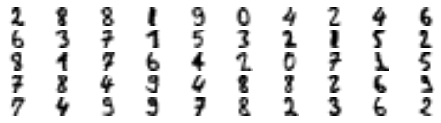

In [64]:
show_sample_digits(X_representative_digits)

Each of the 50 values in X_digits_dist is the distance from each respective centroid. We scanned through all the centroids (columns) and found the corresponding indices of the lowest values in the rows. Now, we're going to assign labels only to these representative images, and train our classifier on them.

In [73]:
y_representative_digits = y_train[representative_digit_idx]
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8955555555555555

Once again, we trained our model on *only 50 instances*, but our accuracy score went up! The next step is to increase our training data set by size by propagating our labels to instances of the same cluster. We don't want to label every single member of the cluster since clustering isn't perfect, but we can perform **label propagation** on the 20% of the cases closest to the cluster centers.

In [89]:
percentile_closest = 20
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
  in_cluster = (kmeans.labels_ == i)
  cluster_dist = X_cluster_dist[in_cluster]
  cutoff_distance = np.percentile(cluster_dist, percentile_closest)
  above_cutoff = (X_cluster_dist > cutoff_distance)
  X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != 1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

In [91]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.9666666666666667

Congratulations, you just saved your team a ton of time and money. Go see a star war.

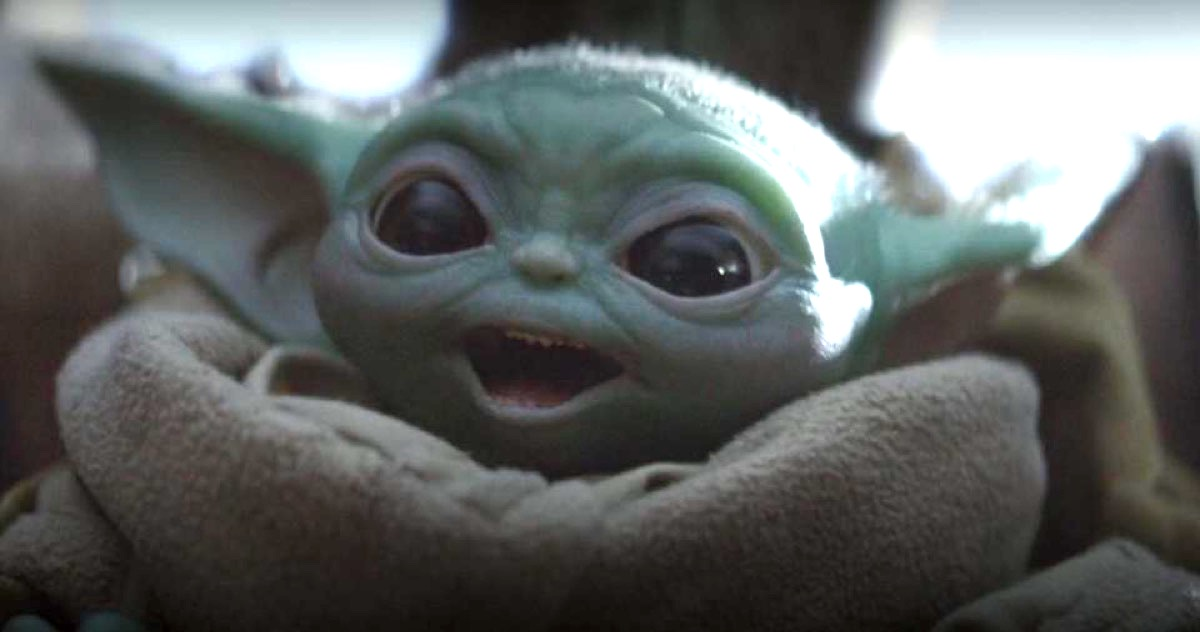